# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import csv
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import keras
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import Sequence, np_utils
from keras.backend import epsilon
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Change directory

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/LabInternal9')

### Load the training data from train.csv file

In [0]:
train_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/LabInternal9/train_labels.csv")

### Print the shape of the train dataset

In [111]:
print(train_data.shape)

(173, 8)


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
# SETTINGS

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

EPOCHS = 10 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

DATASET_FOLDER = "/content/drive/My Drive/Colab Notebooks/LabInternal9/"
TRAIN_CSV = DATASET_FOLDER+"train_labels.csv"
#VALIDATION_CSV = DATASET_FOLDER+"validation.csv"

images_zip_path = DATASET_FOLDER + "images/"

#from zipfile import ZipFile

#with ZipFile(images_zip_path, 'r') as z:
#  z.extractall()

In [138]:
coords = np.zeros((len(path), 4))
coords.shape

(15, 4)

In [0]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    #next(csvfile)
    coords = np.zeros((sum(1 for line in csvfile), 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    for col, row in enumerate(reader):
      if col!=0:           
        for i, r in enumerate(row): # Parse row with seven entities
          #print(row)
          if i == 0:
            row[i] = r
          elif i ==3:
            row[i] =r
          else:  
            row[i] = int(r)
           
        path, image_width, image_height, class_ ,x0, y0, x1, y1 = row 
        #print(row)
        #path = images_zip_path + path
        #print(path)
        coords[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
        coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
        paths.append(path)

In [184]:
print(len(coords))

174


In [150]:
coords[172,3]

92.08888888888889

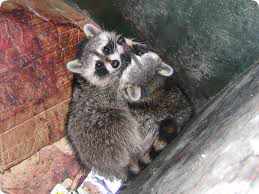

In [206]:
Image.open(paths[119])

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
os.chdir(images_zip_path)
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [153]:
batch_images.shape

(173, 128, 128, 3)

W0714 10:03:55.778672 140344789706624 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


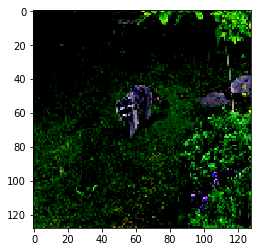

In [125]:
#Showing the first image from the array
plt.imshow(batch_images[0])
plt.show()

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

In [144]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt = coords[1:]

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [187]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE
model.fit(batch_images,gt,epochs=30,batch_size = 32,verbose=1)

Epoch 1/30
173/173 [==============================] - 6s 33ms/step - loss: 3006.2255 - IoU: 0.0653
Epoch 2/30
173/173 [==============================] - 5s 27ms/step - loss: 774.2045 - IoU: 0.3908
Epoch 3/30
173/173 [==============================] - 5s 27ms/step - loss: 651.6277 - IoU: 0.5322
Epoch 4/30
173/173 [==============================] - 5s 26ms/step - loss: 636.9210 - IoU: 0.5212
Epoch 5/30
173/173 [==============================] - 5s 26ms/step - loss: 363.7809 - IoU: 0.5917
Epoch 6/30
173/173 [==============================] - 5s 27ms/step - loss: 286.9002 - IoU: 0.5842
Epoch 7/30
173/173 [==============================] - 5s 27ms/step - loss: 251.0356 - IoU: 0.6033
Epoch 8/30
173/173 [==============================] - 5s 27ms/step - loss: 204.9064 - IoU: 0.6475
Epoch 9/30
173/173 [==============================] - 5s 26ms/step - loss: 172.9885 - IoU: 0.6961
Epoch 10/30
173/173 [==============================] - 5s 28ms/step - loss: 154.0271 - IoU: 0.7168
Epoch 11/30
173/17

### Pick a test image from the given data

In [197]:
paths[1]

'raccoon-11.jpg'

In [0]:
unscaled=Image.open(paths[119])

In [215]:
unscaled.size

(259, 194)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
scaled=unscaled.resize((128, 128))

In [0]:
scaled=preprocess_input(np.array(scaled, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([scaled]))[0] # Predict the BBox

In [219]:
region

array([ 32.581394,  12.125285,  60.349003, 105.046646], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

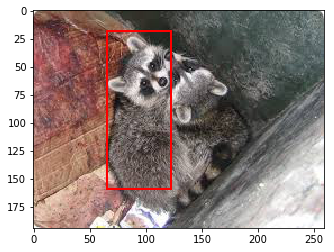

In [220]:
image_width,image_height = unscaled.size
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

#### Change your present working directory

### Load your data file

In [0]:
temp_data = pd.read_csv(DATASET_FOLDER+'daily-minimum-temperatures-in-me.csv')

In [222]:
temp_data.shape

(3650, 2)

In [223]:
temp_data.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


#### Plot data

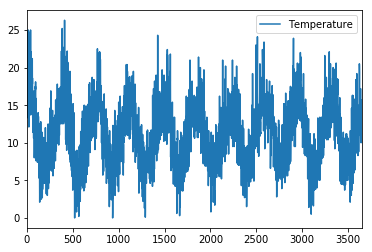

In [224]:
temp_data.plot()

#### Descibe your dataframe

In [226]:
temp_data.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [227]:
temp_data.isna().count()

Date           3650
Temperature    3650
dtype: int64

#### Drop null values

In [0]:
temp_data.dropna(inplace=True)

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa449df3198>]],
      dtype=object)

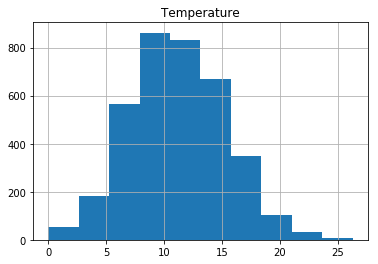

In [233]:
temp_data.hist(bins=10)

#### Check the maximum and minimum values

In [234]:
print('Min\n', np.min(temp_data))
print('Max\n', np.max(temp_data))

Min
 Date           1981-01-01
Temperature             0
dtype: object
Max
 Date           1990-12-31
Temperature          26.3
dtype: object


### Normalize the data

In [0]:
temp_data.set_index('Date',inplace=True)

In [237]:
temp_data.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [0]:
from sklearn.preprocessing import MinMaxScaler
dataset = temp_data.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

#### Check the maximum and minimum values of scaled data

In [240]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [241]:
print(scaled[:10])

[[0.7870723 ]
 [0.68060837]
 [0.71482889]
 [0.55513311]
 [0.60076048]
 [0.60076048]
 [0.60076048]
 [0.66159696]
 [0.82889733]
 [0.7604563 ]]


### Split data into Training and Testing

In [0]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]

#### Print train and test size

In [243]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [245]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [246]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
from keras.layers import LSTM
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Summarize your model

In [250]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [251]:
model.fit(X_train, y_train, epochs=40, batch_size=batch_size, verbose=2, shuffle=True)

W0714 10:43:39.761759 140344789706624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
 - 6s - loss: 0.0203
Epoch 2/40
 - 4s - loss: 0.0163
Epoch 3/40
 - 4s - loss: 0.0136
Epoch 4/40
 - 4s - loss: 0.0126
Epoch 5/40
 - 4s - loss: 0.0118
Epoch 6/40
 - 4s - loss: 0.0115
Epoch 7/40
 - 4s - loss: 0.0111
Epoch 8/40
 - 4s - loss: 0.0109
Epoch 9/40
 - 4s - loss: 0.0107
Epoch 10/40
 - 4s - loss: 0.0106
Epoch 11/40
 - 4s - loss: 0.0104
Epoch 12/40
 - 4s - loss: 0.0103
Epoch 13/40
 - 4s - loss: 0.0103
Epoch 14/40
 - 4s - loss: 0.0102
Epoch 15/40
 - 4s - loss: 0.0103
Epoch 16/40
 - 4s - loss: 0.0102
Epoch 17/40
 - 4s - loss: 0.0101
Epoch 18/40
 - 4s - loss: 0.0102
Epoch 19/40
 - 4s - loss: 0.0101
Epoch 20/40
 - 4s - loss: 0.0102
Epoch 21/40
 - 4s - loss: 0.0101
Epoch 22/40
 - 4s - loss: 0.0102
Epoch 23/40
 - 4s - loss: 0.0102
Epoch 24/40
 - 4s - loss: 0.0101
Epoch 25/40
 - 4s - loss: 0.0102
Epoch 26/40
 - 4s - loss: 0.0102
Epoch 27/40
 - 4s - loss: 0.0102
Epoch 28/40
 - 4s - loss: 0.0102
Epoch 29/40
 - 4s - loss: 0.0102
Epoch 30/40
 - 4s - loss: 0.0101
Epoch 31/40
 - 4s -

## Make Predictions and Evaluate your model

In [252]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.45 RMSE


## Plot the results

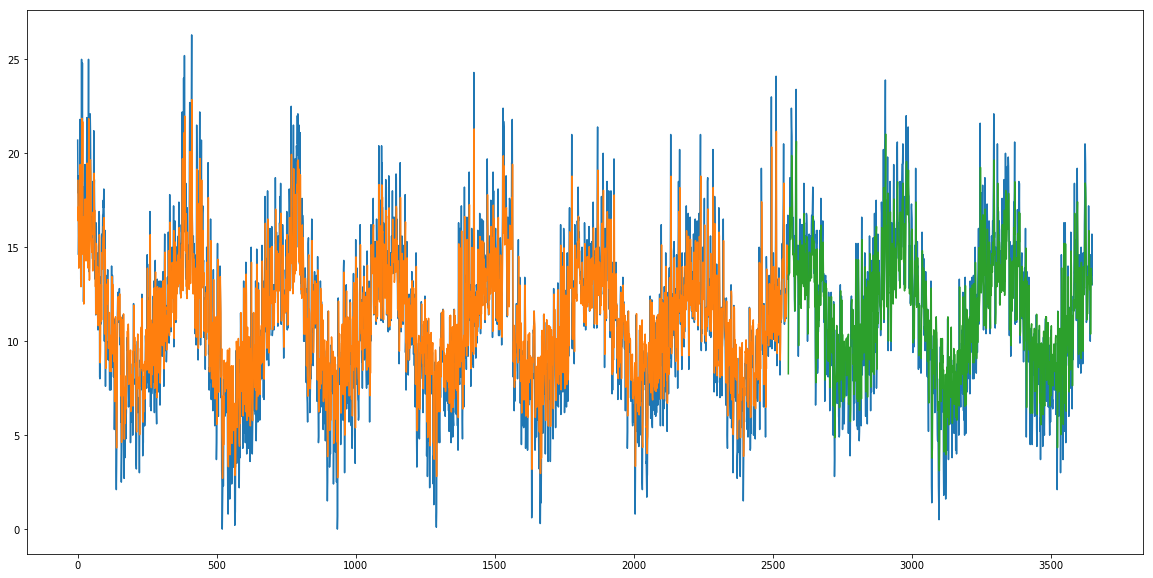

In [253]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()